In [1]:
# %load_ext autoreload
# %autoreload 2

# Set Trial Name

In [2]:
TRIAL_NAME = "39_add_color_feature"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [3]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [4]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [5]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [6]:
import pandas as pd
import numpy as np

sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')

# maker = pd.read_csv('../../data/maker.csv')
maker = pd.read_csv('../../extract_data/maker_rename.csv')

material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')

#production_place = pd.read_csv('../../data/production_place.csv')
production_place = pd.read_csv('../../extract_data/production_place_rename.csv')

technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
test[cfg['target']] = np.nan
train = pd.read_csv('../../data/train.csv')

# del_non_overlapping_list

In [7]:
del_non_overlapping_list = [
    # 'object_id',
    'art_series_id',
    'title',
    #'description',
    #'long_title',
    'principal_maker',
    'principal_or_first_maker',
    #'sub_title',
    'copyright_holder',
    #'more_title',
    'acquisition_method',
    # 'acquisition_date',
    # 'acquisition_credit_line',
    # 'dating_presenting_date',
    # 'dating_sorting_date',
    'dating_period',
    # 'dating_year_early',
    # 'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

In [8]:
def del_non_overlapping(input_df: pd.DataFrame()):
    # for material
    train_oblect_id = train['object_id'].unique().tolist()
    test_oblect_id = test['object_id'].unique().tolist()

    train_value = set(input_df[input_df['object_id'].isin(train_oblect_id)]['name'].unique().tolist())
    test_value = set(input_df[input_df['object_id'].isin(test_oblect_id)]['name'].unique().tolist())

    common_value_list = list(train_value & test_value)

    return input_df[input_df['name'].isin(common_value_list)]

material = del_non_overlapping(material)
historical_person = del_non_overlapping(historical_person)
object_collection = del_non_overlapping(object_collection)
production_place = del_non_overlapping(production_place)

# Merge Data

In [9]:
group = train.groupby('principal_maker')

agg_df = pd.concat([
    group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
    group['sub_title'].nunique().rename('sub_title_num'), # 著者ごとに何種類の sub_title を持っているか
    group['dating_sorting_date'].agg(['min', 'max', 'mean']), # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)
], axis=1)

agg_df.head()

,size,sub_title_num,min,max,mean
principal_maker,,,,,
A. Böeseken,5,5,1858.0,1873.0,1865.8
A. Lutz,1,1,1825.0,1825.0,1825.0
A. Mansuy,2,2,1860.0,1860.0,1860.0
A. Nissen,3,1,1860.0,1860.0,1860.0
A. Roussel,1,1,1905.0,1905.0,1905.0


In [10]:
train = pd.merge(train, 
         agg_df,
         on='principal_maker', 
         how='left')

test = pd.merge(test, 
         agg_df,
         on='principal_maker', 
         how='left')

In [11]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes', 'size', 'sub_title_num', 'min', 'max',
       'mean'],
      dtype='object')

# Feature Enginnering

In [12]:
def create_object_feature(input_df):        
    return input_df['likes'].copy()

create_object_feature(test).head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: likes, dtype: float64

In [13]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]

    return input_df[use_columns].copy()

create_numeric_feature(train).head(2)

,dating_period,dating_year_early,dating_year_late
0,17,1660.0,1685.0
1,19,1900.0,1930.0


In [14]:
def create_categorical_feature(input_df):
    use_columns = [
    #'title',
    'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    ]

    return input_df[use_columns].copy()

create_categorical_feature(test)['principal_maker'].head()

0            Bernardus Bruining
1    Jan Antonisz van Ravesteyn
2               Theodoor Koning
3         Théodore van Lelyveld
4                    Jan Luyken
Name: principal_maker, dtype: object

In [15]:
import pycld2 as cld2

def create_lang_info(input_df):
    
    out_df = pd.DataFrame()
    
    out_df["title_lang"] = input_df["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
    return out_df

create_lang_info(train).head(2)

,title_lang
0,un
1,un


In [16]:
import re

def create_maker_feature(input_df):
    # 本当は時間の処理とかすべき。
    merge_df = pd.merge(input_df['principal_maker'], maker, left_on='principal_maker', right_on='name',how='left')
    merge_df = merge_df.fillna('missing')

    def get_year(text: str):
        match = re.search(r'[0-9]{4}', text)
        if match:
            return match.group()
        else:
            return np.nan
        
    def get_month(text: str):
        match = re.search(r'-[0-9]{2}-', text)
        if match:
            return match.group()[1:-1]
        else:
            return np.nan
    
    # year
    merge_df['date_of_birth_year'] = merge_df['date_of_birth'].apply(lambda x : get_year(x)).astype('float')
    merge_df['date_of_death_year'] = merge_df['date_of_death'].apply(lambda x : get_year(x)).astype('float')
    
    # month
    merge_df['date_of_birth_month'] = merge_df['date_of_birth'].apply(lambda x : get_month(x)).astype('float')
    merge_df['date_of_death_month'] = merge_df['date_of_death'].apply(lambda x : get_month(x)).astype('float')
    
    del_list = [
        'Unnamed: 0',
        'place_of_birth',
        'place_of_death',
        'principal_maker'
    ]
    
    merge_df = merge_df.drop(del_list,axis=1)
    
    return merge_df

create_maker_feature(train).head(2)

,name,date_of_birth,date_of_death,nationality,place_of_birth_country_name,place_of_death_country_name,date_of_birth_year,date_of_death_year,date_of_birth_month,date_of_death_month
0,Jan Hackaert,1628,1705,missing,Netherlands,Netherlands,1628.0,1705.0,NaN,NaN
1,Richard Tepe,1864,1952,missing,Netherlands,Netherlands,1864.0,1952.0,NaN,NaN


In [17]:
def create_material_feature(input_df):
    
    out_df = pd.DataFrame()

    material_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_w2v.csv')
    material_collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_w2v.csv')
    material_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_technique_w2v.csv')
    material_collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_w2v.csv')
    material_collection_technique_production_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_w2v.csv')
    material_collection_technique_production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], material_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]

create_material_feature(train).head(2)

,material_w2v_0,material_w2v_1,material_w2v_2,material_w2v_3,material_w2v_4,material_w2v_5,material_w2v_6,material_w2v_7,material_w2v_8,material_w2v_9,...,material_collection_technique_production_country_w2v_20,material_collection_technique_production_country_w2v_21,material_collection_technique_production_country_w2v_22,material_collection_technique_production_country_w2v_23,material_collection_technique_production_country_w2v_24,material_collection_technique_production_country_w2v_25,material_collection_technique_production_country_w2v_26,material_collection_technique_production_country_w2v_27,material_collection_technique_production_country_w2v_28,material_collection_technique_production_country_w2v_29
0,0.278293,-0.231511,-0.662789,0.991121,0.265224,0.322988,0.102308,-0.456635,-0.190513,-0.944719,...,-0.322543,-0.111608,0.591859,-0.245983,-0.657963,-0.485101,-1.523239,0.461789,0.381441,0.069295
1,0.588832,1.351733,-0.972135,0.362667,-0.376671,-1.124974,0.475698,0.625674,0.555431,-0.876702,...,0.479570,0.600997,-0.478906,-0.229830,1.112767,-0.622317,-0.249008,-0.773201,0.224783,-0.254743


In [18]:
def create_object_collection_feature(input_df):
    collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_w2v.csv')
    collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, collection_technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_object_collection_feature(train).head(2)

,collection_w2v_0,collection_w2v_1,collection_w2v_2,collection_technique_w2v_0,collection_technique_w2v_1,collection_technique_w2v_2,collection_technique_w2v_3,collection_technique_w2v_4,collection_technique_w2v_5,collection_technique_w2v_6,collection_technique_w2v_7,collection_technique_w2v_8,collection_technique_w2v_9
0,-0.649585,-0.883449,1.056636,-0.802673,-0.773696,2.710698,0.041548,-0.239502,-0.667183,-0.838723,-0.637467,0.571580,-0.086521
1,NaN,NaN,NaN,-0.155195,-0.252811,0.461979,0.062138,-0.218526,-0.039926,-0.068988,-0.283977,0.272564,-0.126860


In [19]:
def create_technique_feature(input_df):
    technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_technique_feature(train).head(2)

,technique_w2v_0,technique_w2v_1,technique_w2v_2,technique_w2v_3,technique_w2v_4,technique_w2v_5,technique_w2v_6,technique_w2v_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.230237,-0.075641,0.27766,-0.29013,-0.180698,0.399966,0.128924,-0.01231


In [20]:
def create_historical_person_feature(input_df):
    vc = historical_person['name'].value_counts()
    
    # 出現回数30以上に絞る
    use_names = vc[vc >= 30].index
    
    # isin で 30 回以上でてくるようなレコードに絞り込んでから crosstab を行なう
    idx = historical_person['name'].isin(use_names)
    historical_person_only_famous = historical_person[idx].reset_index(drop=True)
    #print(historical_person_only_famous)
        
    cross_historical_person = pd.crosstab(historical_person_only_famous['object_id'], historical_person_only_famous['name']).reset_index()
    
    input_historical_person = pd.merge(input_df['object_id'], cross_historical_person, on='object_id',how='left')
    input_historical_person.columns = [col.replace(',','') for col in input_historical_person.columns]
    return input_historical_person.iloc[:,1:].add_prefix('HistoricalPerson_')
  
create_historical_person_feature(train).head(2)

,HistoricalPerson_Djatiroto Suikeronderneming,HistoricalPerson_Frederik Hendrik (prins van Oranje),HistoricalPerson_Handels Vereeniging Amsterdam,HistoricalPerson_Jacobus II (koning van Engeland en Schotland),HistoricalPerson_Lodewijk XIV (koning van Frankrijk),HistoricalPerson_Maria II Stuart (koningin van Engeland Schotland en Ierland),HistoricalPerson_Maurits (prins van Oranje),HistoricalPerson_Musschenbroek Sam van,HistoricalPerson_Oldenbarnevelt Johan van,HistoricalPerson_Ruyter Michiel Adriaansz. de,...,HistoricalPerson_Wilhelm II (keizer van Duitsland),HistoricalPerson_Wilhelmina (koningin der Nederlanden),HistoricalPerson_Willem I (prins van Oranje),HistoricalPerson_Willem III (koning der Nederlanden),HistoricalPerson_Willem III (prins van Oranje en koning van Engeland Schotland en Ierland),HistoricalPerson_Willem V (prins van Oranje-Nassau),HistoricalPerson_Wirix F.J.,HistoricalPerson_Witt Cornelis de,HistoricalPerson_Witt Johan de,HistoricalPerson_Álvarez de Toledo Fernando (3e hertog van Alva)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def create_production_place_feature(input_df):

    out_df = pd.DataFrame()

    prodcution_w2v = pd.read_csv('../../../my_pipeline/extract_data/prodcution_w2v.csv')
    production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], prodcution_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:].add_prefix('ProductionPlace_')
  
create_production_place_feature(test).head(2)

,ProductionPlace_production_w2v_0,ProductionPlace_production_w2v_1,ProductionPlace_production_w2v_2,ProductionPlace_production_w2v_3,ProductionPlace_production_w2v_4,ProductionPlace_production_w2v_5,ProductionPlace_production_w2v_6,ProductionPlace_production_w2v_7,ProductionPlace_production_w2v_8,ProductionPlace_production_w2v_9,...,ProductionPlace_production_country_w2v_10,ProductionPlace_production_country_w2v_11,ProductionPlace_production_country_w2v_12,ProductionPlace_production_country_w2v_13,ProductionPlace_production_country_w2v_14,ProductionPlace_production_country_w2v_15,ProductionPlace_production_country_w2v_16,ProductionPlace_production_country_w2v_17,ProductionPlace_production_country_w2v_18,ProductionPlace_production_country_w2v_19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import datetime

def create_acquisition_feature(input_df):
    out_df = pd.DataFrame()
    
    use_columns = [
        'acquisition_date'
    ]
    
    out_df['year'] = pd.to_datetime(input_df['acquisition_date']).dt.year
    out_df['month'] = pd.to_datetime(input_df['acquisition_date']).dt.month
    out_df['dayofweek'] = pd.to_datetime(input_df['acquisition_date']).dt.dayofweek
    out_df['sum_time'] =  10**10 - pd.to_datetime(input_df['acquisition_date']).view('int') // 10**9
    
    return out_df.add_prefix('AcquisitionDate_')

create_acquisition_feature(train).head(2)

,AcquisitionDate_year,AcquisitionDate_month,AcquisitionDate_dayofweek,AcquisitionDate_sum_time
0,1808.0,1.0,4.0,15112288000
1,2000.0,1.0,5.0,9053315200


In [23]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title',
        'description',
        'principal_maker',
        'principal_or_first_maker'
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength__')

create_string_length_feature(train).head(2)

,StringLength__title,StringLength__long_title,StringLength__sub_title,StringLength__more_title,StringLength__description,StringLength__principal_maker,StringLength__principal_or_first_maker
0,5,48,39.0,21.0,NaN,12,12
1,5,64,17.0,15.0,NaN,12,12


In [24]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'acquisition_date',
        'acquisition_credit_line',
        #'art_series_id', 
        'principal_maker',
        'principal_or_first_maker',
        'description', 
        'dating_presenting_date',
        'dating_sorting_date',
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'title',
        'long_title',
        'sub_title',
        'copyright_holder',
        'more_title',
    ]

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

create_count_encoding_feature(train).head(2)

,CE_acquisition_method,CE_acquisition_date,CE_acquisition_credit_line,CE_principal_maker,CE_principal_or_first_maker,CE_description,CE_dating_presenting_date,CE_dating_sorting_date,CE_dating_period,CE_dating_year_early,CE_dating_year_late,CE_title,CE_long_title,CE_sub_title,CE_copyright_holder,CE_more_title
0,4253,48.0,NaN,3,3,NaN,3.0,65.0,3005,65.0,30.0,10516,1,1.0,11313,1.0
1,4253,231.0,NaN,180,180,NaN,77.0,321.0,5042,321.0,214.0,10516,1,1.0,180,1.0


In [25]:
# def create_one_hot_encoding(input_df):
#     use_columns = [
#         'acquisition_method',
#         'principal_maker'
#     ]
#     out_df = pd.DataFrame()
#     for column in use_columns:

#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = train[column].value_counts()
#         vc = vc[vc > 20]

#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(input_df[column], categories=vc.index)

#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

# create_one_hot_encoding(train).head(2)

In [26]:
import re

#  h 166mm × w 78/54mm

def get_h_from_subtitle(text:str):
    match_cm = re.search(r'h \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'h \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100

def get_w_from_subtitle(text:str):
    match_cm = re.search(r'w \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'w \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        elif match_mm.group()[2:-2] == '78/54':
            return float(78)
        else:
            return float(match_mm.group()[2:-2])/100    

def get_t_from_subtitle(text:str):
    match_cm = re.search(r't \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r't \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   

def get_d_from_subtitle(text:str):
    match_cm = re.search(r'd \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'd \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   
        
def create_subtitle_info(input_df):
    out_df = pd.DataFrame()
     
    out_df['subtitle_h'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_h_from_subtitle(x))
    out_df['subtitle_w'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_w_from_subtitle(x))
    out_df['subtitle_t'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_t_from_subtitle(x))
    out_df['subtitle_d'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_d_from_subtitle(x))
    
    out_df['area'] = out_df['subtitle_h'] * out_df['subtitle_w']
    out_df['volume'] = out_df['subtitle_h'] * out_df['subtitle_w'] * out_df['subtitle_t']

    return out_df

create_subtitle_info(test).head(2)

,subtitle_h,subtitle_w,subtitle_t,subtitle_d,area,volume
0,1.67,1.08,NaN,NaN,1.8036,NaN
1,29.70,24.10,NaN,NaN,715.7700,NaN


In [27]:
from util import use_pca

def create_description_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_description_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('DescriptionEmb_')

create_description_emb(test).tail(2)

,DescriptionEmb_pca_0,DescriptionEmb_pca_1,DescriptionEmb_pca_2,DescriptionEmb_pca_3,DescriptionEmb_pca_4,DescriptionEmb_pca_5,DescriptionEmb_pca_6,DescriptionEmb_pca_7,DescriptionEmb_pca_8,DescriptionEmb_pca_9,...,DescriptionEmb_pca_246,DescriptionEmb_pca_247,DescriptionEmb_pca_248,DescriptionEmb_pca_249,DescriptionEmb_pca_250,DescriptionEmb_pca_251,DescriptionEmb_pca_252,DescriptionEmb_pca_253,DescriptionEmb_pca_254,DescriptionEmb_pca_255
12006,4.868668,-2.158481,0.022857,0.005380,-0.005051,-0.033196,-0.030381,0.001403,-0.000757,-0.003157,...,-0.000064,-0.000067,-0.000091,0.000008,0.000044,-0.000033,0.000201,0.000045,-0.000024,-0.000100
12007,-2.857192,-0.279424,-1.757069,-0.255253,-0.783501,-0.267247,-0.262805,-0.261656,0.870815,-0.289136,...,-0.001994,-0.026316,0.001796,-0.004356,0.023299,0.019852,0.020951,0.001647,0.005704,0.004972


In [28]:
from util import use_pca

def create_longtitle_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_longtitle_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('LongTitleEmb_')

create_longtitle_emb(train).tail(2)

,LongTitleEmb_pca_0,LongTitleEmb_pca_1,LongTitleEmb_pca_2,LongTitleEmb_pca_3,LongTitleEmb_pca_4,LongTitleEmb_pca_5,LongTitleEmb_pca_6,LongTitleEmb_pca_7,LongTitleEmb_pca_8,LongTitleEmb_pca_9,...,LongTitleEmb_pca_246,LongTitleEmb_pca_247,LongTitleEmb_pca_248,LongTitleEmb_pca_249,LongTitleEmb_pca_250,LongTitleEmb_pca_251,LongTitleEmb_pca_252,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255
12024,0.134985,0.274562,-0.355269,-0.568043,0.490877,-0.759765,0.800043,0.492068,-0.684610,-0.055678,...,-0.124074,-0.109663,0.011206,0.033923,-0.071635,0.004939,0.036290,-0.151617,0.046685,0.075895
12025,3.315138,0.391916,-0.387958,-0.729402,-0.963970,-1.700653,-0.560265,0.077447,0.027752,-0.265692,...,0.011086,-0.019667,0.018910,-0.077004,-0.060062,-0.031613,0.043291,0.041124,0.057003,0.006189


In [29]:
def create_palette_feature(input_df):
    output_df = input_df.copy()

    # ratio最大のものを取得
    max_palette = palette.groupby('object_id')['ratio'].max().reset_index()
    max_palette = pd.merge(max_palette, palette, on=['object_id','ratio'], how='left').rename(
        columns={"ratio":"max_ratio", "color_r":"max_palette_r", "color_g":"max_palette_g","color_b":"max_palette_b"})  
    max_palette = max_palette.loc[max_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df, max_palette, on="object_id", how="left")

    # 平均のrgbを取得
    mean_palette = palette.copy()
    mean_palette["color_r"] = palette["ratio"] * palette["color_r"]
    mean_palette["color_g"] = palette["ratio"] * palette["color_g"]
    mean_palette["color_b"] = palette["ratio"] * palette["color_b"]
    mean_palette = mean_palette.groupby("object_id").sum().reset_index().rename(
        columns={"color_r":"mean_palette_r", "color_g":"mean_palette_g","color_b":"mean_palette_b"})
    output_df = pd.merge(output_df, mean_palette, on="object_id", how="left")
    
    # rgbの標準偏差を取得
    var_palette = palette.groupby('object_id')[['color_r','color_g','color_b']].std().reset_index().reset_index().rename(
        columns={"color_r":"var_palette_r", "color_g":"var_palette_g","color_b":"var_palette_b"})
    output_df = pd.merge(output_df, var_palette, on="object_id", how="left")
    
#     max_palette = pd.merge(max_palette, palette, on=['object_id','ratio'], how='left').rename(
#         columns={"ratio":"max_ratio", "color_r":"max_palette_r", "color_g":"max_palette_g","color_b":"max_palette_b"})  
#     max_palette = max_palette.loc[max_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
#     output_df = pd.merge(output_df, max_palette, on="object_id", how="left")

    use_columns = ["max_ratio", 
                   "max_palette_r",
                   "max_palette_g",
                   "max_palette_b",
                   "mean_palette_r",
                   "mean_palette_g",
                   "mean_palette_b",
                   "var_palette_r",
                   "var_palette_g",
                   "var_palette_b"
                  ]
    return output_df[use_columns]

create_palette_feature(train).head(10)

,max_ratio,max_palette_r,max_palette_g,max_palette_b,mean_palette_r,mean_palette_g,mean_palette_b,var_palette_r,var_palette_g,var_palette_b
0,0.108754,54.0,30.0,5.0,80.760794,52.411413,10.170802,41.500978,34.432694,16.243813
1,0.095855,70.0,51.0,42.0,93.112586,68.715265,56.557897,30.799625,27.169661,21.839636
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.101774,48.0,44.0,30.0,131.619916,115.351348,53.018787,61.099964,58.025017,45.680449
4,0.122518,29.0,18.0,0.0,84.256844,61.203895,8.837004,37.264237,31.191387,13.540064
5,0.280714,243.0,230.0,211.0,205.582290,192.531062,172.842142,72.304566,70.745275,65.764107
6,0.160220,23.0,18.0,4.0,62.819116,44.809117,13.400003,50.891787,43.046939,21.254640
7,0.066688,165.0,154.0,135.0,164.062598,153.397504,133.655342,50.203913,49.745956,43.490483
8,0.219259,210.0,201.0,147.0,160.997281,143.882203,97.936382,52.836041,57.413213,46.102277
9,0.193920,228.0,207.0,170.0,195.138454,169.559061,129.125616,41.672943,46.230202,47.350402


In [30]:
# from util import use_pca

# def create_image_feature(input_df):
#     out_df = pd.DataFrame()
    
#     all_image_feature = pd.read_pickle('../../extract_data/all_image_feature.pkl').reset_index(drop='True')

#     all_image_feature_256 = use_pca(all_image_feature.iloc[:,1:], 256)
#     all_emb_df_256 = pd.concat([all_image_feature['object_id'], all_image_feature_256], axis=1)
    
#     input_image_feature = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
#     return input_image_feature.iloc[:,1:].add_prefix('ImageFeature_')

# create_image_feature(test).head()

In [31]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [32]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_object_feature,
        create_numeric_feature,
        create_categorical_feature,
        create_lang_info,
        create_maker_feature,
        #create_historical_person_feature,
        create_material_feature,
        create_object_collection_feature,
        create_technique_feature,
        create_production_place_feature,
        create_acquisition_feature,
        create_palette_feature,
        ### create_principal_maker_info_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        #create_one_hot_encoding,
        create_subtitle_info,
        create_description_emb,
        create_longtitle_emb,
        #create_image_feature
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

train_feat= to_feature(train)
test_feat = to_feature(test)

train = train_feat.copy()
test = test_feat.copy()

 31%|███▏      | 5/16 [00:00<00:00, 38.07it/s]

createcreate_object_feature  0.001[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]
createcreate_lang_info  0.052[s]
createcreate_maker_feature  0.061[s]


 44%|████▍     | 7/16 [00:00<00:01,  7.91it/s]

createcreate_material_feature  0.620[s]
createcreate_object_collection_feature  0.062[s]
createcreate_technique_feature  0.034[s]


 56%|█████▋    | 9/16 [00:01<00:00,  8.37it/s]

createcreate_production_place_feature  0.121[s]
createcreate_acquisition_feature  0.016[s]


 81%|████████▏ | 13/16 [00:01<00:00,  6.98it/s]

createcreate_palette_feature  0.508[s]
createcreate_string_length_feature  0.027[s]
createcreate_count_encoding_feature  0.055[s]


 88%|████████▊ | 14/16 [00:01<00:00,  7.03it/s]

createcreate_subtitle_info  0.094[s]


 94%|█████████▍| 15/16 [00:03<00:00,  2.01it/s]

createcreate_description_emb  1.277[s]


 31%|███▏      | 5/16 [00:00<00:00, 38.37it/s]

createcreate_longtitle_emb  1.247[s]
createcreate_object_feature  0.000[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]
createcreate_lang_info  0.047[s]
createcreate_maker_feature  0.064[s]


 44%|████▍     | 7/16 [00:00<00:01,  7.70it/s]

createcreate_material_feature  0.642[s]
createcreate_object_collection_feature  0.063[s]
createcreate_technique_feature  0.033[s]


 56%|█████▋    | 9/16 [00:01<00:00,  8.20it/s]

createcreate_production_place_feature  0.121[s]
createcreate_acquisition_feature  0.014[s]


 69%|██████▉   | 11/16 [00:01<00:00,  5.83it/s]

createcreate_palette_feature  0.492[s]
createcreate_string_length_feature  0.032[s]
createcreate_count_encoding_feature  0.066[s]


 88%|████████▊ | 14/16 [00:01<00:00,  7.07it/s]

createcreate_subtitle_info  0.089[s]


 94%|█████████▍| 15/16 [00:03<00:00,  1.99it/s]

createcreate_description_emb  1.294[s]


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]

createcreate_longtitle_emb  1.282[s]


In [33]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [34]:
# train.to_csv('../EDA/train_for_EDA.csv')
# test.to_csv('../EDA/test_for_EDA.csv')

# train

In [35]:
train.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,LongTitleEmb_pca_246,LongTitleEmb_pca_247,LongTitleEmb_pca_248,LongTitleEmb_pca_249,LongTitleEmb_pca_250,LongTitleEmb_pca_251,LongTitleEmb_pca_252,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255
0,48,17,1660.0,1685.0,other,Jan Hackaert,Jan Hackaert,missing,purchase,un,...,0.004013,-0.034270,-0.016225,0.005202,0.093740,0.012839,0.088617,0.122205,0.000314,-0.090598
1,2,19,1900.0,1930.0,other,Richard Tepe,Richard Tepe,erven Richard Tepe,purchase,un,...,-0.007669,0.059757,0.085707,0.011987,-0.067012,0.109670,-0.056852,0.005023,0.077380,0.011123


In [36]:
# import collections

# collections.Counter(train.columns.tolist())

In [37]:
test.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,LongTitleEmb_pca_246,LongTitleEmb_pca_247,LongTitleEmb_pca_248,LongTitleEmb_pca_249,LongTitleEmb_pca_250,LongTitleEmb_pca_251,LongTitleEmb_pca_252,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255
0,NaN,19,1850.0,1900.0,other,Bernardus Bruining,Bernardus Bruining,missing,transfer,un,...,0.037316,-0.039057,-0.107591,0.009161,-0.036317,0.045925,0.085529,-0.062071,0.054642,-0.039131
1,NaN,17,1609.0,1633.0,other,Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,missing,nationalization 1795,un,...,-0.076793,-0.089827,0.002973,-0.111446,-0.083290,0.067745,-0.035718,0.063161,0.034160,-0.079667


# reduce mem usage

In [38]:
from util import reduce_mem_usage
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 18.81 Mb (61.0% reduction)
Mem. usage decreased to 18.86 Mb (60.8% reduction)


# del_non_overlapping 2

In [39]:
train, test = replace_non_overlap_val_to_missing(train,test,columns=['title_lang'])

# Lable Encoding

In [40]:
cat_col = train.select_dtypes('O').columns.tolist()

In [41]:
cat_col

['art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'name',
 'date_of_birth',
 'date_of_death',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name']

In [42]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [43]:
train.dtypes

likes                     int16
dating_period              int8
dating_year_early       float16
dating_year_late        float16
art_series_id             int64
                         ...   
LongTitleEmb_pca_251    float16
LongTitleEmb_pca_252    float16
LongTitleEmb_pca_253    float16
LongTitleEmb_pca_254    float16
LongTitleEmb_pca_255    float16
Length: 781, dtype: object

# add fold

In [44]:
from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Target Encoding

In [45]:
target_enc_list = [
    # 'title',
    # 'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    'dating_period',
    'title_lang'
]

from fe import target_encoding
train, test = target_encoding(train, 
                              test, 
                              target = cfg['target'], 
                              target_enc_list = target_enc_list, 
                              fold_num = cfg['fold_num']
                             )

principal_maker
principal_or_first_maker
copyright_holder
acquisition_method
dating_period
title_lang


# Make Model

In [46]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [47]:
use_col

['dating_period',
 'dating_year_early',
 'dating_year_late',
 'art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'name',
 'date_of_birth',
 'date_of_death',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name',
 'date_of_birth_year',
 'date_of_death_year',
 'date_of_birth_month',
 'date_of_death_month',
 'material_w2v_0',
 'material_w2v_1',
 'material_w2v_2',
 'material_w2v_3',
 'material_w2v_4',
 'material_w2v_5',
 'material_w2v_6',
 'material_w2v_7',
 'material_w2v_8',
 'material_w2v_9',
 'material_w2v_10',
 'material_w2v_11',
 'material_w2v_12',
 'material_w2v_13',
 'material_w2v_14',
 'material_w2v_15',
 'material_w2v_16',
 'material_w2v_17',
 'material_w2v_18',
 'material_w2v_19',
 'material_collection_w2v_0',
 'material_collection_w2v_1',
 'material_collection_w2v_2',
 'material_collection_w2v_3',
 'material_collection_w2v_4',
 'material_collection_w2v_5',
 'material_collection_w2

In [48]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [49]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False,
  is_target_log=True)

feature_importance_df, order = lgbm.feature_importance(PLOT=False)

--------------FOLDS : 0 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17654	valid_1's rmse: 1.21198
[200]	training's rmse: 1.01186	valid_1's rmse: 1.09208
[300]	training's rmse: 0.941466	valid_1's rmse: 1.06231
[400]	training's rmse: 0.891443	valid_1's rmse: 1.04924
[500]	training's rmse: 0.849709	valid_1's rmse: 1.0416
[600]	training's rmse: 0.812685	valid_1's rmse: 1.03569
[700]	training's rmse: 0.779571	valid_1's rmse: 1.03084
[800]	training's rmse: 0.749403	valid_1's rmse: 1.02741
[900]	training's rmse: 0.72148	valid_1's rmse: 1.02384
[1000]	training's rmse: 0.695379	valid_1's rmse: 1.02078
[1100]	training's rmse: 0.671266	valid_1's rmse: 1.01843
[1200]	training's rmse: 0.648552	valid_1's rmse: 1.01686
[1300]	training's rmse: 0.627204	valid_1's rmse: 1.01481
[1400]	training's rmse: 0.606814	valid_1's rmse: 1.01322
[1500]	training's rmse: 0.587922	valid_1's rmse: 1.01173
[1600]	training's rmse: 0.569702	valid_1's rmse: 1.01056
[1700]	training's rmse: 0.552348	valid_

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17196	valid_1's rmse: 1.22102
[200]	training's rmse: 1.00727	valid_1's rmse: 1.10858
[300]	training's rmse: 0.936993	valid_1's rmse: 1.08311
[400]	training's rmse: 0.887748	valid_1's rmse: 1.07144
[500]	training's rmse: 0.84571	valid_1's rmse: 1.06369
[600]	training's rmse: 0.808513	valid_1's rmse: 1.05753
[700]	training's rmse: 0.775078	valid_1's rmse: 1.05298
[800]	training's rmse: 0.744638	valid_1's rmse: 1.04906
[900]	training's rmse: 0.716399	valid_1's rmse: 1.04546
[1000]	training's rmse: 0.690082	valid_1's rmse: 1.04295
[1100]	training's rmse: 0.665999	valid_1's rmse: 1.0407
[1200]	training's rmse: 0.643096	valid_1's rmse: 1.03826
[1300]	training's rmse: 0.621647	valid_1's rmse: 1.03663
[1400]	training's rmse: 0.601503	valid_1's rmse: 1.03488
[1500]	training's rmse: 0.582521	valid_1's rmse: 1.0334
[1600]	training's rmse: 0.564336	valid_1's rmse: 1.03248
[1700]	training's rmse: 0.547215	valid_1

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17834	valid_1's rmse: 1.20625
[200]	training's rmse: 1.01614	valid_1's rmse: 1.09037
[300]	training's rmse: 0.946291	valid_1's rmse: 1.06096
[400]	training's rmse: 0.896321	valid_1's rmse: 1.04631
[500]	training's rmse: 0.854559	valid_1's rmse: 1.03701
[600]	training's rmse: 0.817279	valid_1's rmse: 1.03083
[700]	training's rmse: 0.783304	valid_1's rmse: 1.02528
[800]	training's rmse: 0.752442	valid_1's rmse: 1.02129
[900]	training's rmse: 0.724121	valid_1's rmse: 1.01809
[1000]	training's rmse: 0.697714	valid_1's rmse: 1.01504
[1100]	training's rmse: 0.673129	valid_1's rmse: 1.01286
[1200]	training's rmse: 0.649937	valid_1's rmse: 1.01097
[1300]	training's rmse: 0.628611	valid_1's rmse: 1.00955
[1400]	training's rmse: 0.608243	valid_1's rmse: 1.00773
[1500]	training's rmse: 0.589053	valid_1's rmse: 1.00579
[1600]	training's rmse: 0.570698	valid_1's rmse: 1.00458
[1700]	training's rmse: 0.553398	vali

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17211	valid_1's rmse: 1.23131
[200]	training's rmse: 1.00766	valid_1's rmse: 1.11996
[300]	training's rmse: 0.936841	valid_1's rmse: 1.09137
[400]	training's rmse: 0.886971	valid_1's rmse: 1.07814
[500]	training's rmse: 0.844659	valid_1's rmse: 1.06939
[600]	training's rmse: 0.807757	valid_1's rmse: 1.06255
[700]	training's rmse: 0.774492	valid_1's rmse: 1.05666
[800]	training's rmse: 0.743725	valid_1's rmse: 1.05194
[900]	training's rmse: 0.715537	valid_1's rmse: 1.04792
[1000]	training's rmse: 0.689148	valid_1's rmse: 1.04423
[1100]	training's rmse: 0.664682	valid_1's rmse: 1.04148
[1200]	training's rmse: 0.641874	valid_1's rmse: 1.03884
[1300]	training's rmse: 0.620555	valid_1's rmse: 1.03617
[1400]	training's rmse: 0.600368	valid_1's rmse: 1.03438
[1500]	training's rmse: 0.581346	valid_1's rmse: 1.03285
[1600]	training's rmse: 0.562874	valid_1's rmse: 1.03165
[1700]	training's rmse: 0.545692	vali

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17542	valid_1's rmse: 1.22168
[200]	training's rmse: 1.0115	valid_1's rmse: 1.0997
[300]	training's rmse: 0.941001	valid_1's rmse: 1.06961
[400]	training's rmse: 0.890574	valid_1's rmse: 1.05646
[500]	training's rmse: 0.847866	valid_1's rmse: 1.04755
[600]	training's rmse: 0.810448	valid_1's rmse: 1.04165
[700]	training's rmse: 0.776994	valid_1's rmse: 1.03694
[800]	training's rmse: 0.746188	valid_1's rmse: 1.03311
[900]	training's rmse: 0.717453	valid_1's rmse: 1.03014
[1000]	training's rmse: 0.691189	valid_1's rmse: 1.02782
[1100]	training's rmse: 0.666427	valid_1's rmse: 1.02551
[1200]	training's rmse: 0.643436	valid_1's rmse: 1.02379
[1300]	training's rmse: 0.621778	valid_1's rmse: 1.02214
[1400]	training's rmse: 0.601405	valid_1's rmse: 1.02135
[1500]	training's rmse: 0.582239	valid_1's rmse: 1.01986
[1600]	training's rmse: 0.564202	valid_1's rmse: 1.01883
[1700]	training's rmse: 0.547261	valid_

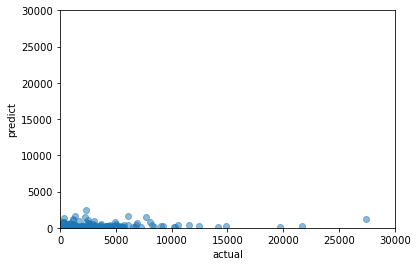

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(train['likes'],lgbm.oof,alpha=0.5);
plt.xlim(0,30000);
plt.ylim(0,30000);
plt.xlabel('actual');
plt.ylabel('predict');

In [51]:
train[train['likes'] < 50]

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255,fold,principal_maker_target_enc,principal_or_first_maker_target_enc,copyright_holder_target_enc,acquisition_method_target_enc,dating_period_target_enc,title_lang_target_enc
0,48,17,1660.0,1685.0,0,638,638,25,6,13,...,0.122192,0.000314,-0.090576,0,34.000000,34.000000,84.717660,93.411989,166.412056,81.003403
1,2,19,1900.0,1930.0,0,1042,1041,23,6,13,...,0.005024,0.077393,0.011124,0,12.470588,12.470588,12.470588,93.411989,54.370800,81.003403
2,5,19,1860.0,1880.0,0,1202,1212,25,2,10,...,0.003914,0.056091,0.034058,0,159.857923,158.856244,84.717660,62.250801,54.370800,4.427848
4,7,19,1825.0,1874.0,0,1194,1194,25,8,13,...,0.086060,0.010658,-0.180176,0,22.865972,23.358289,84.717660,11.147402,54.370800,81.003403
5,0,19,1867.0,1867.0,0,174,175,25,2,13,...,-0.066040,-0.088989,-0.081238,0,3.000000,3.000000,84.717660,62.250801,54.370800,81.003403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12020,6,20,1935.0,1936.0,0,1194,1194,25,6,13,...,-0.088440,-0.053528,0.005363,4,23.889527,24.341410,83.251353,90.179818,36.716475,77.494111
12021,4,19,1900.0,1920.0,0,295,296,25,7,13,...,-0.007896,-0.005672,0.022491,4,NaN,NaN,83.251353,20.151635,58.355755,77.494111
12022,0,18,1701.0,1714.0,0,13,13,25,6,13,...,0.052917,-0.023575,-0.026306,4,0.444444,0.444444,83.251353,90.179818,55.729022,77.494111
12023,0,18,1778.0,1778.0,0,916,915,25,7,13,...,-0.044281,-0.088806,0.200073,4,1.000000,1.000000,83.251353,20.151635,55.729022,77.494111


In [52]:
os.makedirs(f"{OUTPUT_DIR}/imp", exist_ok=True)
feature_importance_df[order[:50]].to_csv(f"{OUTPUT_DIR}/imp/importance.csv")
display(feature_importance_df[order[:50]])

,material_collection_technique_w2v_19,material_collection_w2v_19,material_collection_technique_w2v_3,material_collection_technique_production_country_w2v_7,principal_maker,principal_or_first_maker,subtitle_h,principal_maker_target_enc,collection_w2v_1,principal_or_first_maker_target_enc,...,LongTitleEmb_pca_0,mean_palette_r,mean_palette_g,LongTitleEmb_pca_138,DescriptionEmb_pca_40,LongTitleEmb_pca_12,name,DescriptionEmb_pca_3,LongTitleEmb_pca_15,LongTitleEmb_pca_110
fold_0,151361.340814,90777.807003,151435.188029,31890.402982,32101.463537,17435.952136,12664.440916,18585.247460,16993.424286,19522.377014,...,1344.247324,2206.061152,2293.102686,1661.314666,1225.806466,2276.319001,2938.904741,3138.418091,1871.734582,1926.807413
fold_1,106560.373333,94662.319878,232545.811793,32162.802620,28086.866173,21718.374850,12655.926411,17448.119290,1382.415009,19923.278423,...,2967.006570,1484.185146,2041.890446,1437.940437,1624.305418,2914.867471,2216.440566,2978.451257,1946.455637,1347.035701
fold_2,53797.445112,14927.750785,209575.044607,29517.250881,24861.148448,26293.931378,18549.022214,19619.981186,81585.847229,18859.205043,...,1926.480633,2063.757174,1549.737122,1205.450442,1134.718140,2464.100257,1851.643102,3809.767238,1347.262629,2057.549552
fold_3,124432.658802,77567.821838,144463.956634,13053.084789,30422.009998,24220.175623,11374.671891,16959.370537,18192.886383,16475.371213,...,1513.263677,2095.781356,1619.779964,1791.354272,2942.910402,1680.613735,3737.045383,2140.661514,1332.474537,1488.843554
fold_4,240421.569048,106064.449004,77199.260363,29269.766008,28324.525246,22818.981602,21538.623388,17115.827512,16538.826019,16355.789106,...,2248.004645,2240.098851,2231.274048,2151.912876,2122.128880,2057.700216,2019.169695,1998.429150,1939.614020,1890.591805


In [53]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [54]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [55]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [56]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210310220037_39_add_color_feature/pred/pred_likes_1.0128.csv


In [57]:
sub_df.describe()

,likes
count,12008.000000
mean,22.161341
std,65.411516
min,0.000000
25%,1.102023
50%,2.599020
75%,6.577621
max,1780.286440


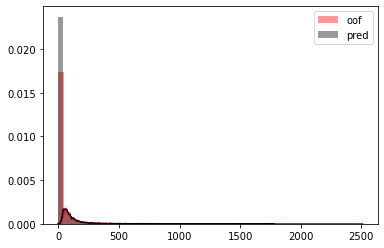

In [58]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)